In [1]:
import numpy as np
import tensorflow as tf

import matplotlib as mpl
import matplotlib.pyplot as plt
import preprocessing

import collections

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
data_path = "../data"

## Most Common Song Finder

In [4]:
train_id, test_id, vocab, relevance, lp = preprocessing.preprocess(directory='../data_info/data/', train_test_split=0.8, k=2)

song_counter = collections.Counter(train_id)

n_most_common = 40
most_common_tokens, most_common_occurrences = zip(*song_counter.most_common(n_most_common))

## Convert the tokens back to words so that we can see what they are
token_to_word_dict = {i:w for w, i in vocab.items()}
most_common_songs = [token_to_word_dict[t] for t in most_common_tokens]

print(*zip(most_common_songs, most_common_occurrences), sep = ", ")

('<BREAK>', 1001), ('Closer', 61), ('Roses', 49), ('Caroline', 48), ('Home', 47), ('Bad and Boujee (feat. Lil Uzi Vert)', 46), ('HUMBLE.', 44), ('Congratulations', 43), ('1-800-273-8255', 43), ('One Dance', 43), ('Starboy', 38), ('Broccoli (feat. Lil Yachty)', 37), ('XO TOUR Llif3', 36), ('Panda', 36), ('Let Me Love You', 36), ('goosebumps', 35), ('Selfish', 35), ('Ride', 35), ('Redbone', 34), ('Mask Off', 34), ('Trouble', 33), ('Stay', 33), ('Chill Bill', 33), ("Don't", 33), ('Hotline Bling', 33), ('Trap Queen', 32), ('rockstar', 32), ('Passionfruit', 32), ('Down', 32), ('Forever', 32), ('Unforgettable', 32), ('Shape of You', 32), ('Jungle', 31), ('Sorry', 31), ('Location', 31), ("I'm the One", 31), ('Black Beatles', 31), ('No Problem (feat. Lil Wayne & 2 Chainz)', 31), ('Slide', 30), ('Hold On', 30)


NameError: name 'most_common_words' is not defined

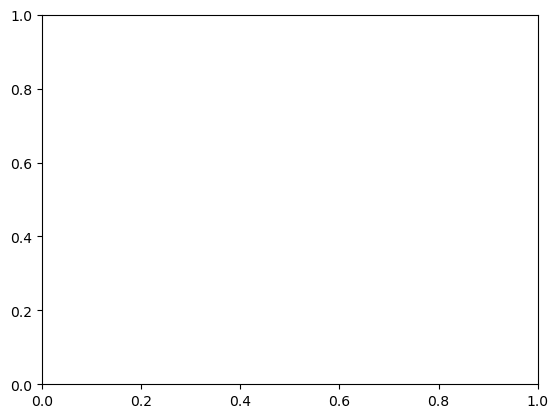

In [5]:
fig_most_common, ax_top50_most_common = plt.subplots()
ax_top50_most_common.barh(y = most_common_words,
                          width = most_common_occurrences, 
                          height = 0.75, 
                          color = "C0", 
                          edgecolor = "black", 
                          zorder = 100)

ax_top50_most_common.grid(linestyle = "dashed", 
                          color = "#bfbfbf", 
                          zorder = -100)

ax_top50_most_common.set_yticks(ticks = ax_top50_most_common.get_yticks())
ax_top50_most_common.set_yticklabels(labels = most_common_words, 
                                     fontsize = 14)

ax_top50_most_common.invert_yaxis()

fig_most_common.set_size_inches([6, 12])

### Run The Model

In [ ]:
%%time

import rnn

train_id, test_id, vocab, relevance, lp = preprocessing.preprocess(directory='../data_info/data/', train_test_split=0.8, k=3)

train_id = np.array(train_id)
test_id  = np.array(test_id)    

# Training and validation are aligned because we require the input song for RPrecision
X0, Y0 = train_id, train_id
X1, Y1 = test_id,  test_id

args = rnn.get_text_model(vocab, relevance)

data = args.model.fit(
    X0, Y0,
    epochs=2, 
    batch_size=lp,
    validation_data=(X1, Y1)
)

Epoch 1/2
136/136 [==============================] - 690s 5s/step - loss: 8.7365 - RPrecision: 0.0154 - val_loss: 5.7621 - val_RPrecision: 0.0123
Epoch 2/2
 70/136 [==============>...............] - ETA: 4:22 - loss: 5.6617 - RPrecision: 0.0154

### Generate Playlist

In [ ]:
def RPrecision(predictions, labels):
        PAD_TOKEN = 0
        #print(prediction_arr)
        predict_set = set(predictions)
        labels = labels[:len(predict_set)]
        
        ground_truth = set(labels)

        # Return mean of running total to get running mean
        return len(predict_set.intersection(ground_truth)) / len(ground_truth)

## Feel free to mess around with the word list to see the model try to generate sentences
for word1 in ['Creep']:
    if word1 not in vocab: print(f"{word1} not in vocabulary")            
    else: print(args.model.generate_recommendations(word1, 10, vocab))
    print()

ids = relevance[vocab['Creep']]
id_to_track = {id: name for name, id in vocab.items()}
tracks =[id_to_track[id] for id in ids]
print(tracks[:30])
print()
print("R-Precision: " + str(RPrecision(args.model.generate_recommendations(word1, 10, vocab), [id_to_track[x] for x in relevance[vocab['Creep']]])))